In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve,r2_score
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from autogluon.tabular import TabularDataset,TabularPredictor
import shutil
import graphviz
import dtreeviz


In [3]:
# rf寻找最优参数
def rf_best_param(X_train,y_train,n_estimators_range,k=5):
    """默认为5折交叉验证,评价指标为R2"""
    # 设置树的数目范围
    n_estimators_range = n_estimators_range
    cv_scores = []
    # 使用交叉验证
    for n_estimators in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
        scores = cross_val_score(rf,X_train, y_train, cv=k, scoring='accuracy')  # K折交叉验证 分类问题默认使用accuracy
        cv_scores.append(scores.mean())
    # 选择最优数量的树
    optimal_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
    return optimal_n_estimators

In [4]:
# 存储采样结果CSV文件的路径
sample_csv = r"D:\ArcgisData\pred_tl\pred_table\test\feature_table_result"
# 输出CSV文件的名称
sample_csv_name = "feature_table_result.csv" 
# 随机森林树的范围
n_estimators_range = range(10, 2000, 200)
# 模型存储路径
modle_save_path = r"D:\ArcgisData\pred_tl\pred_table\test\test_modle\autogluon_model" 


In [5]:
# 读取CSV文件使用rf训练模型
data = pd.read_csv(os.path.join(sample_csv,sample_csv_name))
print(data.columns)

Index(['亚类', '土属', '土种', '土类', 'TWI5', 'TPI201', 'TPI101', 'TPI11', 'TPI3',
       'TMP', 'SOILQS', 'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP',
       'PLCUR', 'POCUR', 'LON', 'LAT', 'PH', 'DL', 'SC2', 'OSJL', 'SOM', 'DZ'],
      dtype='object')


In [6]:
# 特征因子
feature_list = ['TWI5', 'TPI201', 'TPI101', 'TPI11', 'TPI3','TMP', 'SOILQS', 'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP','PLCUR', 'POCUR', 'LON', 'LAT', 'PH', 'DL', 'SC2', 'OSJL', 'SOM', 'DZ']
target_label = "土类"

In [7]:
data = data[feature_list+[target_label]]
# 列类型转换
data["SC2_label"] = data.SC2.astype("category").cat.codes
data["DL_label"] = data.DL.astype("category").cat.codes
data["DZ_label"] = data.DZ.astype("category").cat.codes
data["TL_label"] = data.土类.astype("category").cat.codes
data.sample()

,TWI5,TPI201,TPI101,TPI11,TPI3,TMP,SOILQS,SLOP,PRE,NIGTH,...,DL,SC2,OSJL,SOM,DZ,土类,SC2_label,DL_label,DZ_label,TL_label
352,5.695438,20.1875,9.428223,0.105835,0.010376,142.5,12,12.481797,856.3333,0.22,...,2.0,3,359.2005,29.98085,1,紫色土,2,1,0,2


In [8]:
# 数据划分
features = ['TWI5', 'TPI201','TMP', 'SLOP','PRE', 'NIGTH', 'NDVI', 'DEM','PH', 'OSJL', 'SOM', 'SC2_label','DL_label', 'DZ_label']
targets = "TL_label"
X = data[features]
y = data[targets]


In [9]:
test_data = pd.concat([X,y],axis=1)

In [10]:
# 划分训练集和测试集
train_data,test_data = train_test_split(test_data,test_size=0.2,random_state=0)

In [12]:
# 训练模型
predictor = TabularPredictor(label=targets, path=modle_save_path).fit(train_data,presets="best_quality",time_limit=10800)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "D:\ArcgisData\pred_tl\pred_table\test\test_modle\autogluon_model\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   445.67 GB / 808.56 GB (55.1%)
Train Data Rows:    1819
Train Data Columns: 14
Label Column: TL_label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [3, 2, 1, 0, 4]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to pre

In [13]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_BAG_L1,0.916484,0.915338,2.614377,0.623937,65.010805,2.614377,0.623937,65.010805,1,True,3
1,ExtraTreesGini_BAG_L1,0.914286,0.912589,0.075011,0.062000,0.293763,0.075011,0.062000,0.293763,1,True,9
2,ExtraTreesEntr_BAG_L1,0.914286,0.911490,0.076737,0.066000,0.331966,0.076737,0.066000,0.331966,1,True,10
3,NeuralNetFastAI_BAG_L2,0.914286,0.921385,27.201484,5.006545,628.704143,2.557086,0.844965,65.625625,2,True,15
4,ExtraTreesGini_BAG_L2,0.912088,0.916987,24.705151,4.214881,563.408916,0.060753,0.053301,0.330398,2,True,21
5,WeightedEnsemble_L3,0.912088,0.925234,26.394425,4.750260,619.575746,0.006999,0.000000,0.204976,3,True,26
6,NeuralNetTorch_BAG_L2,0.912088,0.919186,28.956752,6.444686,651.379270,4.312354,2.283106,88.300752,2,True,24
7,LightGBMXT_BAG_L1,0.909890,0.913139,2.351498,0.766818,36.830409,2.351498,0.766818,36.830409,1,True,4
8,CatBoost_BAG_L1,0.909890,0.912589,3.994259,0.219007,193.042962,3.994259,0.219007,193.042962,1,True,8
9,ExtraTreesEntr_BAG_L2,0.909890,0.919736,24.706199,4.229669,563.399750,0.061801,0.068089,0.321232,2,True,22


In [15]:
predictor.leaderboard(train_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesGini_BAG_L1,0.998351,0.912589,0.059999,0.062000,0.293763,0.059999,0.062000,0.293763,1,True,9
1,RandomForestEntr_BAG_L1,0.998351,0.912040,0.060192,0.084731,0.434784,0.060192,0.084731,0.434784,1,True,7
2,ExtraTreesEntr_BAG_L1,0.998351,0.911490,0.063727,0.066000,0.331966,0.063727,0.066000,0.331966,1,True,10
3,RandomForestGini_BAG_L1,0.998351,0.913139,0.090000,0.059000,0.346800,0.090000,0.059000,0.346800,1,True,6
4,LightGBMLarge_BAG_L1,0.998351,0.912589,4.089273,0.917943,71.196728,4.089273,0.917943,71.196728,1,True,13
5,KNeighborsDist_BAG_L1,0.996152,0.640462,0.004001,0.002003,0.003103,0.004001,0.002003,0.003103,1,True,2
6,LightGBM_BAG_L1,0.992303,0.914788,1.016561,0.351586,32.307323,1.016561,0.351586,32.307323,1,True,5
7,WeightedEnsemble_L2,0.991754,0.924684,15.170177,2.898653,395.306528,0.004000,0.001000,0.216773,2,True,14
8,CatBoost_BAG_L2,0.991754,0.919736,17.974569,4.587019,1456.503586,0.358559,0.425438,893.425068,2,True,20
9,LightGBMXT_BAG_L2,0.985706,0.923035,18.921960,4.617406,618.687246,1.305950,0.455826,55.608728,2,True,16


In [16]:
best_model = predictor.get_model_best()
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.925234       4.750260   619.575746                0.000000           0.204976            3       True         26
1       WeightedEnsemble_L2   0.924684       2.898653   395.306528                0.001000           0.216773            2       True         14
2         LightGBMXT_BAG_L2   0.923035       4.617406   618.687246                0.455826          55.608728            2       True         16
3           LightGBM_BAG_L2   0.921385       4.529043   649.688241                0.367463          86.609723            2       True         17
4    NeuralNetFastAI_BAG_L2   0.921385       5.006545   628.704143                0.844965          65.625625            2       True         15
5            XGBoost_BAG_L2   0.920286       4.554812   640.820126  

d:\worker_code\.venvgis\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L2': 'Stacke

In [17]:
# 查看准确率
y_test = test_data[targets]
y_train = train_data[targets]
y_test_pred= predictor.predict(test_data)
y_train_pred = predictor.predict(train_data)
r2_test = accuracy_score(y_test,y_test_pred)
r2_train = accuracy_score(y_train,y_train_pred)
print(r2_test,r2_train)

0.9120879120879121 0.982957669048928


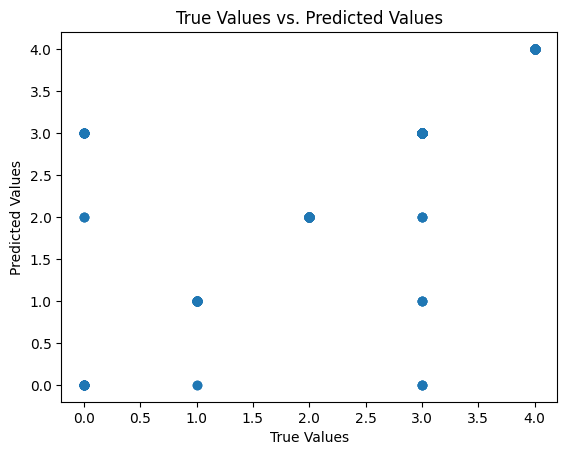

In [18]:
# 预测散点图
plt.scatter(y_test.values, y_test_pred)

# 添加标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')

# 显示图表
plt.show()

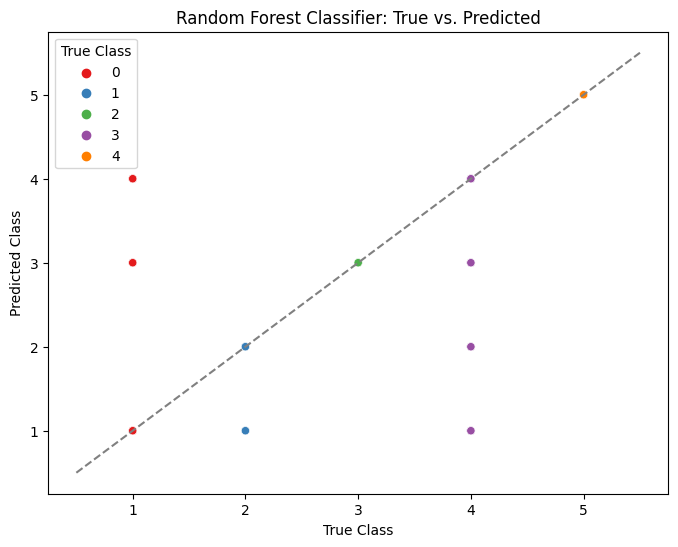

In [19]:
# 创建分类散点图
df =  pd.DataFrame({'True Class': y_test, 'Predicted Class': y_test_pred})
class_names = [1,2,3,4,5]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='True Class', y='Predicted Class', hue='True Class', palette='Set1')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('Random Forest Classifier: True vs. Predicted')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.legend(title='True Class')
plt.plot([-0.5, len(class_names) - 0.5], [-0.5, len(class_names) - 0.5], '--', color='gray')
plt.show()

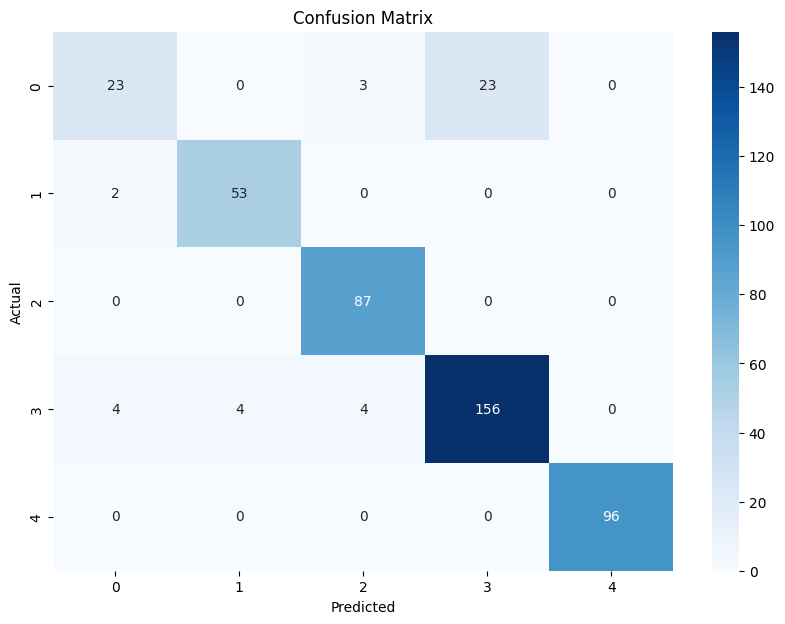

In [20]:
# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

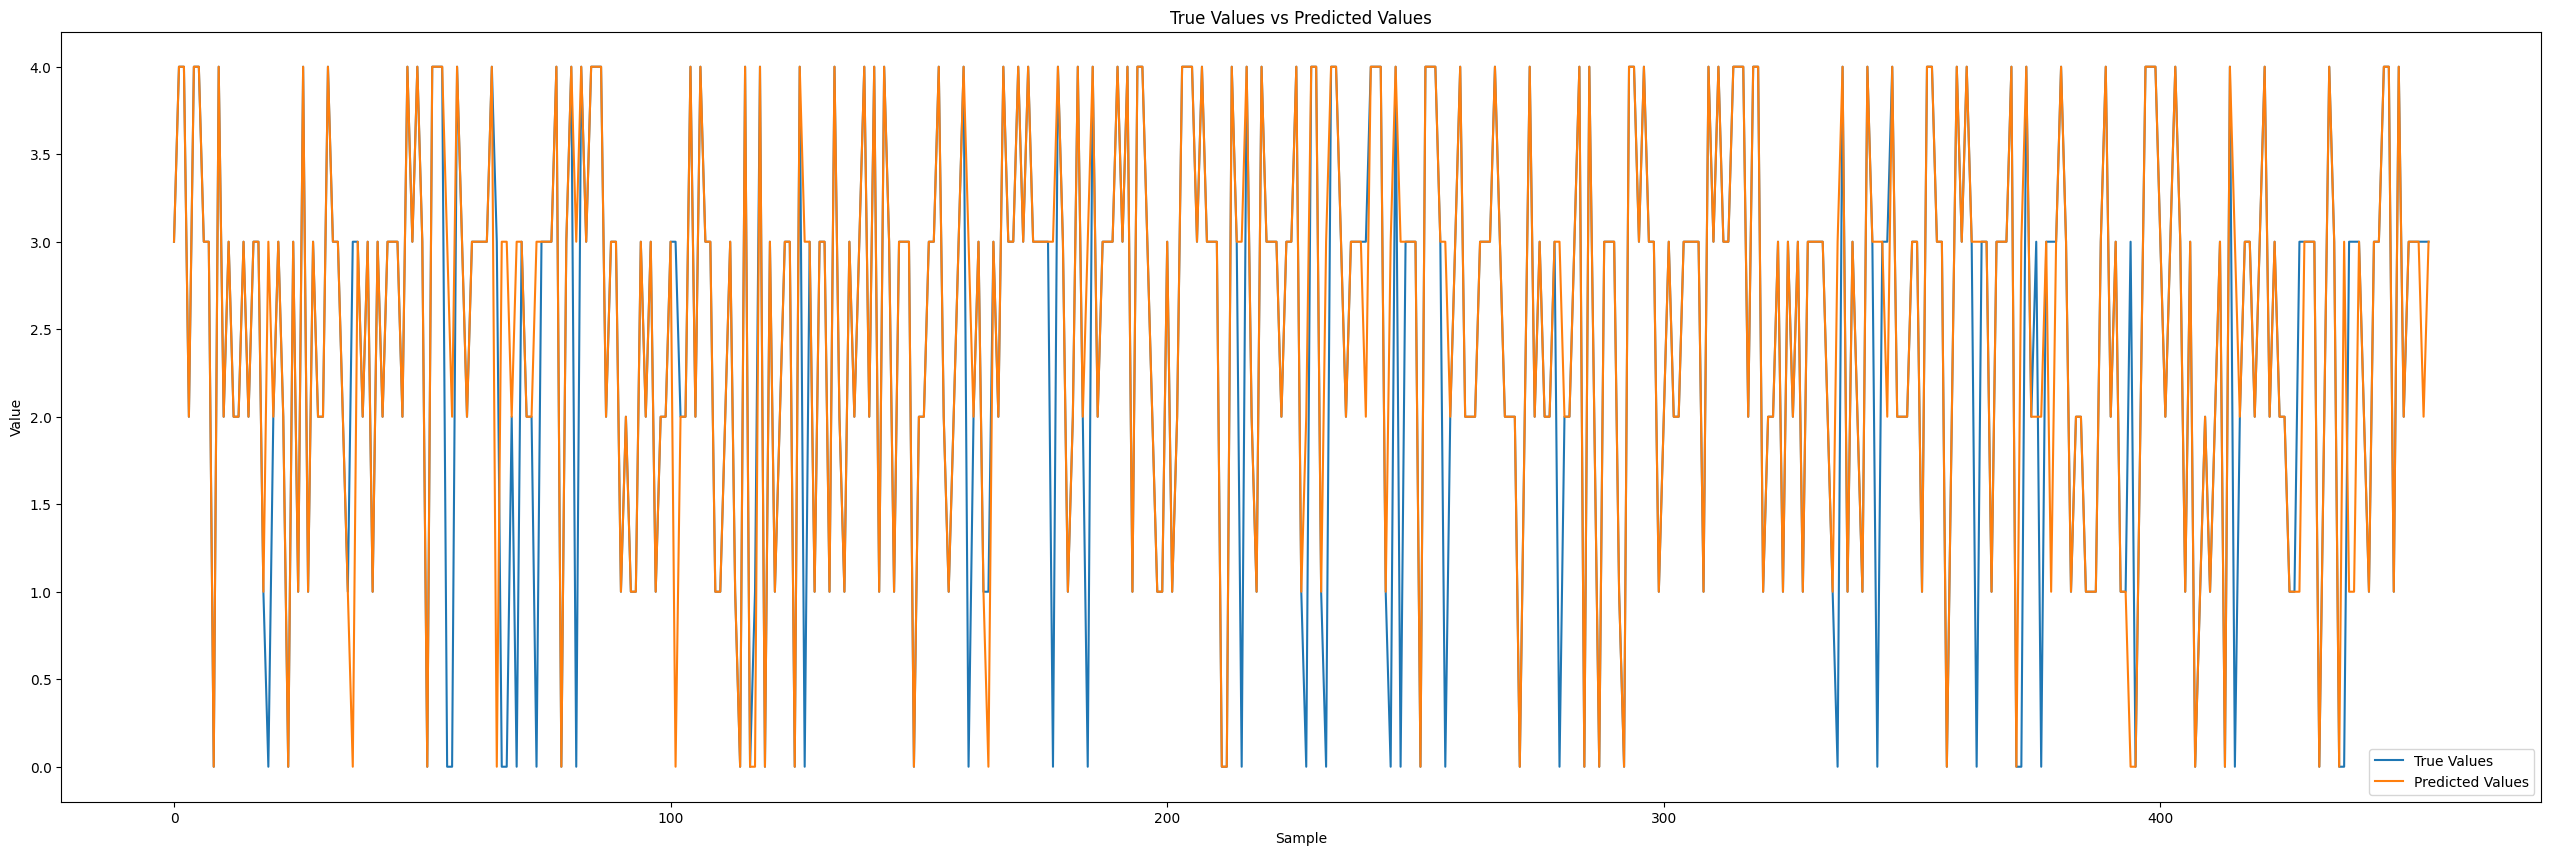

In [21]:
# 创建折线图
plt.figure(figsize=(32,10))
plt.plot(y_test.values, label='True Values')
plt.plot(y_test_pred.values, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()